In [114]:
((np.exp(LR / 2) - 1) / LR).shape

(128, 16)

In [118]:
type(LR)

numpy.ndarray

In [97]:
nplt

6

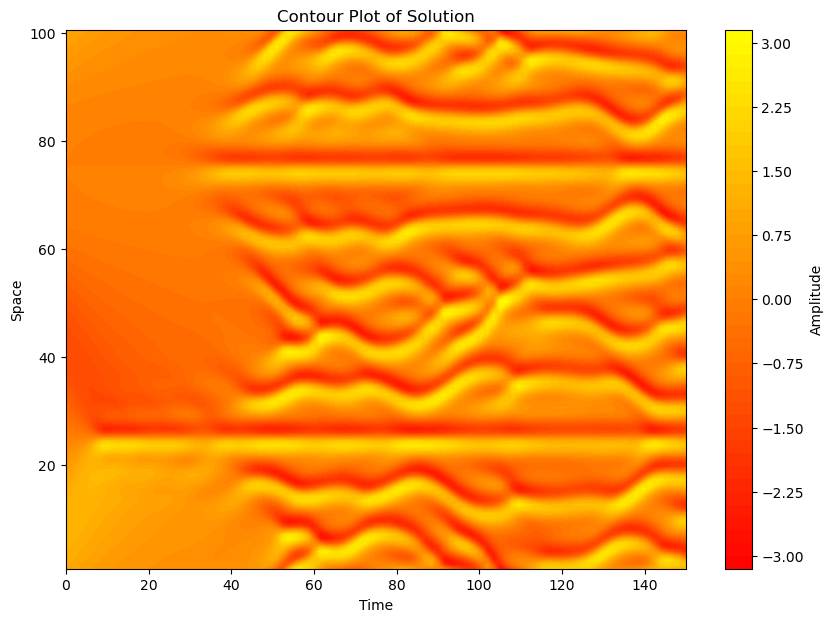

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Spatial grid and initial condition
N = 128
x = 32 * np.pi * np.arange(1, N+1) / N
u = np.cos(x/16) * (1 + np.sin(x/16))
v = np.fft.fft(u)

# Precompute various ETDRK4 scalar quantities
h = 1/4  # time step
k = np.concatenate([np.arange(0, N//2),[0], np.arange(-N//2+1, 0)]) / 16  # wave numbers
L = k**2 - k**4  # Fourier multipliers
E = np.exp(h * L)
E2 = np.exp(h * L / 2)
M = 16  # number of points for complex means
r = np.exp(1j * np.pi * (np.arange(1, M+1) - 0.5) / M)  # roots of unity

LR = h * L[:, None] + r[None, :]
Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR**2)) / LR**3, axis=1))
f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR**3, axis=1))
f3 = h * np.real(np.mean((-4 - 3 * LR - LR**2 + np.exp(LR) * (4 - LR)) / LR**3, axis=1))

# Main time-stepping loop
uu = u
tt = [0]
tmax = 150
nmax = round(tmax / h)
nplt = int(np.floor((tmax / 100) / h))
g = -0.5j * k

for n in range(1, nmax+1):
    t = n * h
    Nv = g * np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E2 * v + Q * Nv
    Na = g * np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E2 * v + Q * Na
    Nb = g * np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E2 * a + Q * (2 * Nb - Nv)
    Nc = g * np.fft.fft(np.real(np.fft.ifft(c))**2)
    
    v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3
    
    if n % nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.vstack([uu, u])
        tt.append(t)

# Plot results using a contour plot
fig, ax = plt.subplots(figsize=(10, 7))
X, T = np.meshgrid(x, tt)
contour = ax.contourf(T, X, uu, levels=50, cmap=cm.autumn)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Amplitude')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Contour Plot of Solution')

plt.show()


In [119]:
from matplotlib.animation import FuncAnimation, PillowWriter

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, uu[0], color='blue')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(uu.min(), uu.max())
ax.set_xlabel('Space')
ax.set_ylabel('Amplitude')
ax.set_title('Change in Spatial Dimension Over Time')

# Update function for the animation
def update(frame):
    line.set_ydata(uu[frame])
    ax.set_title(f'Change in Spatial Dimension Over Time (t = {tt[frame]/20:.2f})')
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tt), interval=50, blit=True)

# Save the animation as a GIF file
ani.save('spatial_dimension_over_time.gif', writer=PillowWriter(fps=20))

plt.close(fig)